# <span style='color:Red'> Assignment 3 : In this code I develop an algorithm to read the screenplays and automatically predict the genre of the movie. 

# Import Libraries

In [13]:
from bs4 import BeautifulSoup
import urllib.request
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import re
import time
import os
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skmultilearn.problem_transform import LabelPowerset, BinaryRelevance, ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import nltk
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\14379\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\14379\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Get links to scripts: Web scrape the Internet Movie Script Database (IMDSDb) to extract links to each of their scripts and also find the script's genres. Note : Each script can have more than one genre.
## The genres:  Action, Adventure, Animation, Comedy, Drama, Fantasy, Horror, Mystery, Romance, Sci-Fi, and Thriller.

In [54]:
def fetch(url):
    request = urllib.request.Request(url)
    try:
        read_request = urllib.request.urlopen(request).read()#.decode('utf-8')
        return read_request
    except urllib.error.HTTPError:
        return False
    
def movie_title_from_hyperlink(hyperlink):
    return hyperlink["href"][len(script_link_first_part):-len(script_link_last_part)].replace(":", "")

script_folder_url = 'http://www.imsdb.com/scripts/'
genre_folder_url = 'http://www.imsdb.com/genre/'

script_link_first_part = "/Movie Scripts/"
script_link_last_part = " Script.html"

genres = [
    "Action",
    "Adventure",
    "Animation",
    "Comedy",
    "Drama",
    "Fantasy",
    "Horror",
    "Mystery",
    "Romance",
    'Sci-Fi',
    'Thriller',
]

# Number of samples from each genre
samples_from_genres = []

# "Recent comments" is a side-bar linking to random scripts. Needs to be filtered out
nr_of_recent_comments = 5

# A dictionary with movie title as key. Each movie in the dictionary
# links to a list with all of its genres
movie_dict = dict([])

for i, genre in enumerate(genres):
    
    # Crawl IMSDb for genre
    genre_url = genre_folder_url + genre
    request_text = fetch(genre_url)
    soup = BeautifulSoup(request_text, "html5lib")
    all_hyperlinks = soup.find_all("a", href=True)
    
    found_scripts = 0
    # Get all movies from genre
    for hyperlink in all_hyperlinks:
        if script_link_first_part in hyperlink["href"]: # Check if it is a link to a movie script
            
            found_scripts += 1
            if found_scripts > nr_of_recent_comments:
                
                title = movie_title_from_hyperlink(hyperlink)

                if title not in movie_dict:
                    movie_dict[title] = [0]*len(genres)
                movie_dict[title][i] = 1
    samples_from_genres.append(found_scripts - 5)
    print("nr of movies from", genre, "is", found_scripts - 5)
    
print("Number of links: %d" % ( len(movie_dict) ))

nr of movies from Action is 336
nr of movies from Adventure is 203
nr of movies from Animation is 45
nr of movies from Comedy is 394
nr of movies from Drama is 652
nr of movies from Fantasy is 130
nr of movies from Horror is 158
nr of movies from Mystery is 123
nr of movies from Romance is 211
nr of movies from Sci-Fi is 180
nr of movies from Thriller is 406
Number of links: 1203


# Extract information from all links and get scripts, movie names, and genre


In [55]:
def get_movie_script(movie_title):
    
    script_url = script_folder_url + movie_title.strip(":").replace(" ","-") + ".html"
    request_text = fetch(script_url)
    
    if not request_text: # Check if we got error when attempting to fetch script url
        return ""
    
    soup = BeautifulSoup(request_text, "html5lib")
    
    script = soup.findAll("pre") #
    script_text = ""
    
    if script:
        script_text = script[-1].get_text() # Get all text within most inner "<pre>...</pre>"
    
    return script_text

titles = []
scripts = []
labels = []

In [57]:
for i, movie_title in enumerate(movie_dict.keys()):
    script = get_movie_script(movie_title)
    if script != "": # Check if the script was found
        titles.append(movie_title)
        scripts.append(script.replace("\n"," ").replace("\\",""))
        labels.append(movie_dict[movie_title])
    
    if i % 5 == 0: # Just to see progress
        print(i)

scripts_and_labels = {"titles": np.array(titles), "scripts":np.array(scripts), "labels": np.array(labels)}

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200


# Save/Load scripts to a pickle file 


In [58]:
pickle.dump(scripts_and_labels , open( "pickled_scripts_and_labels.p", "wb" ),protocol=4)

In [14]:
scripts_and_labels = pickle.load(open( "pickled_scripts_and_labels.p", "rb" ))

## Preprocess all scripts: We use nltk to break the script into tokens and apply word Lemmatization and StanfordNERTagger to extract all the names from the script and remove them

In [66]:
os.environ["JAVAHOME"] = "C:\\Programming_Languages\\Java\\jre\\bin\\"
nltk.internals.config_java("C:/Programming_Languages/Java/bin/java.exe")
st = StanfordNERTagger('resources/english.all.3class.distsim.crf.ser.gz','resources/stanford-ner.jar', encoding='utf-8')

lmtzr = WordNetLemmatizer()

def preprocess(doc, stops):
    doc = doc.split()
    script_extra_stop_words = {"contd", "ext", "int", "wwwimsdbcom", "script", "continued", "wwwscreentalkorg", "pdf", "imsdb",
                              "int","cont","continued","fran","lynn","marlene","nick","beth","catherine","sid","audrey","willie","indiana","indy","marcus","jack","rachel","jackie","luke","jack","david","michael","anne","digger","sean","rothsam","lynn","william","bob","phil","charlotte","betty","larry","andrew","matt","joe","steve","danny","benedict","evelyn","ellie","trevor","hammond","alan","doug","browning","kate","harvey","charlie","barnes"}
    stops = stops.union(script_extra_stop_words)
    classified_text = st.tag(doc)
    t1 = time.time()
    new_doc = []
    for i, word in enumerate(doc):
        new_word = lmtzr.lemmatize(re.sub(r'\W+', '', word)).replace("/","")
    
    for i, word in enumerate(doc):
        
        if new_word != "" and i < len(classified_text) and classified_text[i][0] == word.replace("/","") and classified_text[i][1] != "PERSON":
            new_doc.append(new_word.lower())
            
    print(time.time()-t1, "seconds")
    return ' '.join(doc)

preprocessed_scripts = []
for script in scripts_and_labels["scripts"]:
    preprocessed_scripts.append(preprocess(script, stops))  
preprocessed_scripts = np.array(preprocessed_scripts)
print("Preprocessed all scripts")

1.6125292778015137 seconds
0.10870099067687988 seconds
0.10373044013977051 seconds
0.09076571464538574 seconds
0.10371899604797363 seconds
0.11219668388366699 seconds
0.12566089630126953 seconds
0.10571670532226562 seconds
0.0030167102813720703 seconds
0.0917668342590332 seconds
0.11864089965820312 seconds
0.10272002220153809 seconds
0.13766074180603027 seconds
0.09873580932617188 seconds
0.0957784652709961 seconds
0.12267184257507324 seconds
0.09616923332214355 seconds
0.13553595542907715 seconds
0.1237025260925293 seconds
0.12067461013793945 seconds
0.0708160400390625 seconds
0.09973311424255371 seconds
0.10497879981994629 seconds
0.09282183647155762 seconds
0.15559625625610352 seconds
0.11339712142944336 seconds
0.11072921752929688 seconds
0.13701796531677246 seconds
0.11472773551940918 seconds
0.11682891845703125 seconds
0.15238118171691895 seconds
0.18936920166015625 seconds
0.10372304916381836 seconds
0.1246488094329834 seconds
0.09178280830383301 seconds
0.12133574485778809 seco

0.09075713157653809 seconds
0.11066603660583496 seconds
0.0847768783569336 seconds
0.09573936462402344 seconds
0.14265227317810059 seconds
0.10073351860046387 seconds
0.10970640182495117 seconds
0.11087226867675781 seconds
0.0987558364868164 seconds
0.11968326568603516 seconds
0.08977437019348145 seconds
0.11768388748168945 seconds
0.08078384399414062 seconds
0.11769866943359375 seconds
0.08680319786071777 seconds
0.15262293815612793 seconds
0.10675549507141113 seconds
0.11372590065002441 seconds
0.1376662254333496 seconds
0.0887765884399414 seconds
0.10172867774963379 seconds
0.12368106842041016 seconds
0.11269831657409668 seconds
0.13663339614868164 seconds
0.09379458427429199 seconds
0.12366938591003418 seconds
0.10870981216430664 seconds
0.14162993431091309 seconds
0.0828084945678711 seconds
0.1107032299041748 seconds
0.09973335266113281 seconds
0.09474396705627441 seconds
0.14374732971191406 seconds
0.11472797393798828 seconds
0.10772490501403809 seconds
0.11668801307678223 second

0.09917807579040527 seconds
0.12501287460327148 seconds
0.09513449668884277 seconds
0.16660094261169434 seconds
0.09609651565551758 seconds
0.1117403507232666 seconds
0.10537052154541016 seconds
0.0878610610961914 seconds
0.12713074684143066 seconds
0.11065363883972168 seconds
0.14684629440307617 seconds
0.09914159774780273 seconds
0.13600635528564453 seconds
0.09174942970275879 seconds
0.11774587631225586 seconds
0.09964513778686523 seconds
0.10123014450073242 seconds
0.11217546463012695 seconds
0.1107490062713623 seconds
0.15987849235534668 seconds
0.08628368377685547 seconds
0.09746789932250977 seconds
0.14044737815856934 seconds
0.09605956077575684 seconds
0.14826273918151855 seconds
0.11396431922912598 seconds
0.1373140811920166 seconds
0.0899043083190918 seconds
0.07796359062194824 seconds
0.13545465469360352 seconds
0.11392450332641602 seconds
0.11208653450012207 seconds
0.1105337142944336 seconds
0.09635400772094727 seconds
0.1686387062072754 seconds
0.1392841339111328 seconds


0.26508378982543945 seconds
0.13972949981689453 seconds
0.12812376022338867 seconds
0.1223301887512207 seconds
0.2653052806854248 seconds
0.06680941581726074 seconds
0.20004725456237793 seconds
0.21517014503479004 seconds
0.1137397289276123 seconds
0.14852023124694824 seconds
0.1311933994293213 seconds
0.09948015213012695 seconds
0.12229490280151367 seconds
0.13434886932373047 seconds
0.15583014488220215 seconds
0.13190340995788574 seconds
0.1141366958618164 seconds
0.21125483512878418 seconds
0.11736702919006348 seconds
0.2064666748046875 seconds
0.1580193042755127 seconds
0.11646509170532227 seconds
0.10120296478271484 seconds
0.19875240325927734 seconds
0.13957953453063965 seconds
0.180344820022583 seconds
0.14373326301574707 seconds
0.11807918548583984 seconds
0.11524558067321777 seconds
0.09736919403076172 seconds
0.07442331314086914 seconds
0.1272878646850586 seconds
0.14220380783081055 seconds
0.10862231254577637 seconds
0.09993529319763184 seconds
0.14884543418884277 seconds
0.

0.09958863258361816 seconds
0.11193060874938965 seconds
0.1652529239654541 seconds
0.11284089088439941 seconds
0.09658360481262207 seconds
0.11210799217224121 seconds
0.13207077980041504 seconds
0.14348173141479492 seconds
0.11451339721679688 seconds
0.09321475028991699 seconds
0.11456894874572754 seconds
0.1013643741607666 seconds
0.11178851127624512 seconds
0.09110045433044434 seconds
0.10553669929504395 seconds
0.10952615737915039 seconds
0.13122057914733887 seconds
0.1586759090423584 seconds
0.13029742240905762 seconds
0.33962416648864746 seconds
0.19263243675231934 seconds
0.17058682441711426 seconds
0.07814621925354004 seconds
0.06252360343933105 seconds
0.20050334930419922 seconds
Preprocessed all scripts


# Save/Load preprocessed scripts to a pickle file 


In [67]:
pickle.dump(preprocessed_scripts , open( "pickled_preprocessed_scripts.p", "wb" ))

In [15]:
preprocessed_scripts = pickle.load(open( "pickled_preprocessed_scripts.p", "rb" ))

# Example of the preprocessed scripts

In [69]:
unpickled_df = pd.read_pickle("pickled_preprocessed_scripts.p")
unpickled_df

array(['FADE IN on the words CZECH AIRLINE. We are panning across the words on the side of the plane. INT. AIRPLANE ANGLE DOWN on a tray table. Crumpled Czech bills and coins are on it. Hands are counting the money. The airline hostess announces the arrival at JFK - in CZECH. A hand reaches into a breast pocket - pulling out two passports. One is opened. Belongs to EMIL SLOVAK. The next passport belongs to OLEG RAZGUL. The hand passes the Oleg Razgul passport to the man next to him. We notice several empty airline bottles of vodka and a small disposable camera on Oleg\'s tray table. The passport is set down. Oleg picks it up. We hear Emil\'s voice in CZECH. The scene is subtitled in ENGLISH. EMIL (V.O.) Just do what I do. Say the same thing I say. Don\'t open your mouth. OLEG (V.O.) Okay. INT. PASSPORT CONTROL - KENNEDY AIRPORT - DAY CAMERA DOLLIES down a long line of passengers. They are split into two lines - one for Americans, the other for visitors. CAMERA finally arrives at EMIL S

## Compute tf-idf to only include words with 10% frequency

In [16]:
transvector = TfidfVectorizer(stop_words = "english", min_df = 0.1, max_df = 0.5, strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
scripts_tfidf = transvector.fit_transform(preprocessed_scripts)
vocab = dict([[v,k] for k,v in transvector.vocabulary_.items()])
print(len(transvector.idf_))

7940


# Split into training and test: We now have the words from the scripts in one column and the movie genres in the label column and we will split it to train and test

In [17]:
# Shuffle the scripts_tfidf and labels together
rng = np.random.seed(None)
p = np.random.permutation(scripts_tfidf.shape[0])
scripts_tfidf = scripts_tfidf[p]
labels = np.array(scripts_and_labels["labels"])[p]
movie_names = np.array(scripts_and_labels["titles"])[p]

print('Length of lables', len(scripts_and_labels["labels"]))
print('Length of scripts', len(preprocessed_scripts))
cut_point = int(scripts_tfidf.shape[0]/2)

x_test = scripts_tfidf[:cut_point]
y_test = labels[:cut_point]
titles_test = movie_names[:cut_point]

x_train = scripts_tfidf[cut_point:]
y_train = labels[cut_point:]
titles_train = movie_names[cut_point:]

print("Successfully split data into training and test")


Length of lables 1205
Length of scripts 1205
Successfully split data into training and test


# Classify each genre: First, we will classify by each genre and see if we can find if the script belongs to a specific genre or not

In [224]:
final_preds = []
genre = []
accuracy_of_genre = []
precision_of_genre = []
recall_of_genre = []
samples_in_genre = []
for genre_index in range(len(genres)):
    genre_y_train = np.array([x[genre_index] for x in y_train])#.reshape(-1, 1)
    genre_y_test = np.array([x[genre_index] for x in y_test])#.reshape(-1, 1)

    #classifier = ensemble.ExtraTreesClassifier(n_estimators=100) 
    #classifier = ensemble.RandomForestClassifier(n_estimators=100)
    classifier = MLPClassifier()
                        
    classifier.fit(x_train, genre_y_train)
    pred = classifier.predict(x_test)                        
    accuracy = accuracy_score(genre_y_test,pred)
    precision = precision_score(genre_y_test,pred)
    recall = recall_score(genre_y_test,pred)

    print("Genre:", genres[genre_index])
    genre.append(genres[genre_index])    
    print("Accuracy:", accuracy)
    accuracy_of_genre.append(accuracy)
    print("Recall is:", recall)
    recall_of_genre.append(recall)
    print("Precision is:", precision)
    precision_of_genre.append(precision)
    samples_in_genre.append(samples_from_genres[genre_index])
    print("Samples in genre:", samples_from_genres[genre_index])   
    print("")
    df = pd.DataFrame(list(zip(genre , accuracy_of_genre, recall_of_genre,precision_of_genre, samples_in_genre)), 
           columns =['Genre', 'Accuracy','Recall', 'Precision', 'Samples in Genre']) 

    if genre_index == 0:
        final_preds = [[pred[x]] for x in range(len(genre_y_test))]
    else:
        for i in range(len(pred)):
            final_preds[i].append(pred[i])

Genre: Action
Accuracy: 0.872093023255814
Recall is: 0.7794871794871795
Precision is: 0.8172043010752689
Samples in genre: 336

Genre: Adventure
Accuracy: 0.8887043189368771
Recall is: 0.5841584158415841
Precision is: 0.7023809523809523
Samples in genre: 203

Genre: Animation
Accuracy: 0.96843853820598
Recall is: 0.05
Precision is: 1.0
Samples in genre: 45

Genre: Comedy
Accuracy: 0.7973421926910299
Recall is: 0.6470588235294118
Precision is: 0.6836158192090396
Samples in genre: 394

Genre: Drama
Accuracy: 0.729235880398671
Recall is: 0.7834394904458599
Precision is: 0.7214076246334311
Samples in genre: 652

Genre: Fantasy
Accuracy: 0.8970099667774086
Recall is: 0.2647058823529412
Precision is: 0.6
Samples in genre: 130

Genre: Horror
Accuracy: 0.8920265780730897
Recall is: 0.44680851063829785
Precision is: 0.7636363636363637
Samples in genre: 158

Genre: Mystery
Accuracy: 0.9069767441860465
Recall is: 0.14285714285714285
Precision is: 0.8181818181818182
Samples in genre: 123

Genre: R

In [225]:
df.to_csv('Results.csv',index=True)
print(df)

        Genre  Accuracy    Recall  Precision  Samples in Genre
0      Action  0.872093  0.779487   0.817204               336
1   Adventure  0.888704  0.584158   0.702381               203
2   Animation  0.968439  0.050000   1.000000                45
3      Comedy  0.797342  0.647059   0.683616               394
4       Drama  0.729236  0.783439   0.721408               652
5     Fantasy  0.897010  0.264706   0.600000               130
6      Horror  0.892027  0.446809   0.763636               158
7     Mystery  0.906977  0.142857   0.818182               123
8     Romance  0.820598  0.245098   0.446429               211
9      Sci-Fi  0.888704  0.461538   0.813559               180
10   Thriller  0.808970  0.672897   0.761905               406


# Second we train a classifier to predict all the genres for each movie: We compare Extratrees, random forest, and MLP classifiers. MLP has the best accuracy, recall, and precision. 
## As we notice, the accuracy is 23,3% only which is considered bad accuracy. The problem is that we have 11 labels ( Genres ), and each movie has from one to six categories of the genres, so it is hard to predict all the genre categories correct for each movie.

In [183]:
#classifier = ensemble.ExtraTreesClassifier(n_estimators=100) 
#classifier = ensemble.RandomForestClassifier(n_estimators=100)
classifier = MLPClassifier()
classifier.fit(x_train, y_train)
preds = classifier.predict(x_test)

pred_distr = preds.sum(axis=0,  dtype='int')
y_train_distr = y_train.sum(axis=0,  dtype='int') 
y_test_distr = y_test.sum(axis=0,  dtype='int')

accuracy = accuracy_score(y_test,preds)
print("my accuracy is:", accuracy)

recall = recall_score(y_test, preds, labels = range(1,11), average = 'micro')
print("my recall is:", recall)

precision = precision_score(y_test, preds, labels = range(1,11), average = 'micro')
print("my precision is:", precision)

my accuracy is: 0.23421926910299004
my recall is: 0.5201262825572218
my precision is: 0.7387892376681614


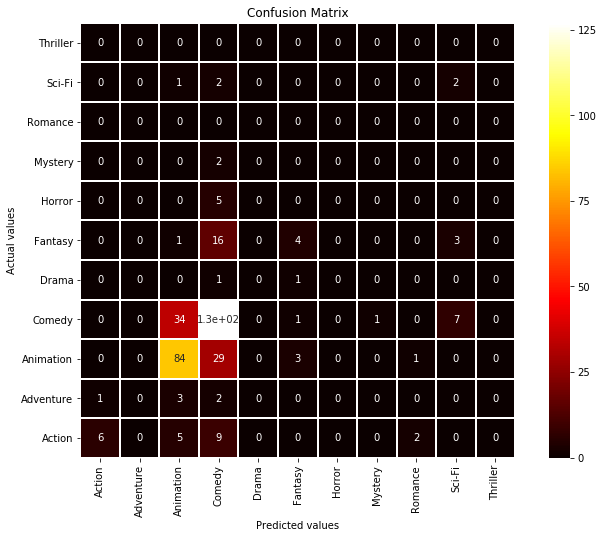

In [213]:
cm = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1), labels = range(1,12))
fig, ax = plt.subplots(figsize=(12,8))
axis_labels = ["Action",
    "Adventure",
    "Animation",
    "Comedy",
    "Drama",
    "Fantasy",
    "Horror",
    "Mystery",
    "Romance",
    'Sci-Fi',
    'Thriller']
ax = sns.heatmap(data=cm, annot=True, cmap='hot', xticklabels=axis_labels, yticklabels=axis_labels, linewidths=1, square=True,ax = ax)
ax.set_ylim(0, 11)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix')
plt.show()

## Print the correctly predicted movies with all genres from test data:

In [160]:
def print_prediction_genres(pred_array):
    """Prints the predicted genres from a prediction array."""
    print([genre for index, genre in enumerate(genres) if list(pred_array)[index] == 1])

def pred_equal_ytest(x):
    """x is the prediction's index"""
    return sum([1 for y in range(len(preds[x])) if int(preds[x,y]) == int(y_test[x,y])]) == len(genres)

number_of_correct_scripts = 0
for x in range(len(preds)):        
    if pred_equal_ytest(x):
    #if not pred_equal_ytest(x):
        print(titles_test[x], end=" - ")
        print_prediction_genres(preds[x])
        number_of_correct_scripts += 1
print(number_of_correct_scripts)

Austin Powers - The Spy Who Shagged Me - ['Action', 'Comedy']
Braveheart - ['Action', 'Drama']
Wall Street - ['Drama']
Hostage - ['Action', 'Drama', 'Thriller']
Darkman - ['Action', 'Sci-Fi', 'Thriller']
Die Hard - ['Action', 'Thriller']
Alien - ['Action', 'Horror', 'Sci-Fi', 'Thriller']
30 Minutes or Less - ['Action', 'Adventure', 'Comedy']
Mr Blandings Builds His Dream House - ['Comedy']
Abyss, The - ['Action', 'Adventure', 'Sci-Fi', 'Thriller']
Shame - ['Drama']
Believer, The - ['Drama']
Capote - ['Drama']
Producer, The - ['Comedy']
Le Diable par la Queue - ['Comedy']
Elephant Man, The - ['Drama']
Drive - ['Action', 'Drama']
Man on the Moon - ['Comedy', 'Drama']
TRON Legacy - ['Action', 'Adventure', 'Sci-Fi']
King of Comedy, The - ['Comedy', 'Drama']
Mud - ['Drama']
Get on Up - ['Drama']
Batman - ['Action', 'Fantasy', 'Thriller']
Big Sick, The - ['Comedy', 'Drama', 'Romance']
Escape From L.A. - ['Action', 'Adventure', 'Sci-Fi', 'Thriller']
Assassins - ['Action', 'Thriller']
Cirque d